# Goal
Diversity, unconscious bias in the workplace and, in general, the way companies treat their employees are a very important topic. Data science can help discover potential discriminations by looking at the data and see if there are segments of employees that are treated worse.

# Description
There has been lots of talking about diversity in the workplace, especially in technology. The Head of HR at your company is very concerned about that and has asked you to analyze internal data about employees and see whether results suggest that the company is treating its employees fairly.

Specifically, she gave you the following tasks:
* In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
    - Individual Contributors (IC) - they don't manage anyone 
    - Middle Managers (MM) - they are the direct bosses of IC 
    - Directors (D) - they are the direct bosses of MM
    - VP - D direct bosses
    - Executives (E) - VP direct bosses
    - CEO - The direct boss of E.
* How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.
* Build a model to predict the salary of each employee.
* Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset

In [2]:
company = pd.read_csv('./data/HR/company_hierarchy.csv')
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [3]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
employee_id    10000 non-null int64
boss_id        9999 non-null float64
dept           10000 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
employee = pd.read_csv('./data/HR/employee.csv')
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [5]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
employee_id       10000 non-null int64
signing_bonus     10000 non-null int64
salary            10000 non-null float64
degree_level      10000 non-null object
sex               10000 non-null object
yrs_experience    10000 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 468.8+ KB


In [6]:
employee.describe()

,employee_id,signing_bonus,salary,yrs_experience
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,0.301400,189111.800000,3.875200
std,57500.488641,0.458889,88973.796898,3.107409
min,40.000000,0.000000,60000.000000,1.000000
25%,50574.500000,0.000000,110000.000000,2.000000
50%,99244.500000,0.000000,182000.000000,3.000000
75%,149748.500000,1.000000,255000.000000,5.000000
max,199956.000000,1.000000,700000.000000,34.000000


In [7]:
# merge employee and company information
data = pd.merge(left=employee, right=company, on='employee_id')
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


# Question 1
In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
* Individual Contributors (IC) - they don't manage anyone
* Middle Managers (MM) - they are the direct bosses of IC
* Directors (D) - they are the direct bosses of MM
* VP - D direct bosses
* Executives (E) - VP direct bosses
* CEO - The direct boss of E.

In [8]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
data.loc[data['dept'] == 'CEO', 'level'] = 'CEO'

for i in range(len(levels) - 1):
    boss_level = levels[i]
    empl_level = levels[i + 1]
    boss_id = data[data['level'] == boss_level]['employee_id']
    data.loc[data['boss_id'].isin(boss_id), 'level'] = empl_level

In [9]:
data[['employee_id', 'level']].sample(10)

,employee_id,level
9307,18710,IC
5302,143655,IC
7614,139073,IC
301,10492,IC
8131,94379,IC
542,171990,IC
9223,162586,IC
9285,15019,IC
8218,14515,IC
3282,134671,MM


In [10]:
# value counts for each group
data['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

# Question 2
How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [11]:
# find the managed employees for each employee
data['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = data[data['level'] == level]['boss_id']
    employee_ids = data[data['level'] == level]['employee_id']
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + data.loc[data['employee_id'] == e_id, 'counts'])
        b_counts = int(data.loc[data['employee_id'] == b_id, 'counts'])
        data.loc[data['employee_id'] == b_id, 'counts'] = e_counts + b_counts

In [12]:
data[['employee_id', 'level', 'counts']].sample(10)

,employee_id,level,counts
1786,191289,MM,13
6421,40726,IC,0
6938,49166,IC,0
1964,61403,D,66
4968,117021,IC,0
7476,188389,IC,0
3264,104957,IC,0
3420,25568,IC,0
1787,158402,IC,0
2774,177560,IC,0


# Question 3
Build a model to predict the salary of each employee.

In [13]:
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,counts
0,138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
2,114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
3,29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


### Visualization

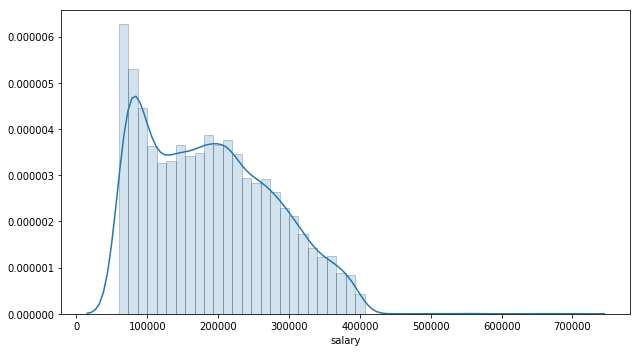

In [14]:
# Distribution of salary
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(9, 5))
sns.distplot(data['salary'], ax=ax, hist_kws=hist_kws)
plt.tight_layout()
plt.show()

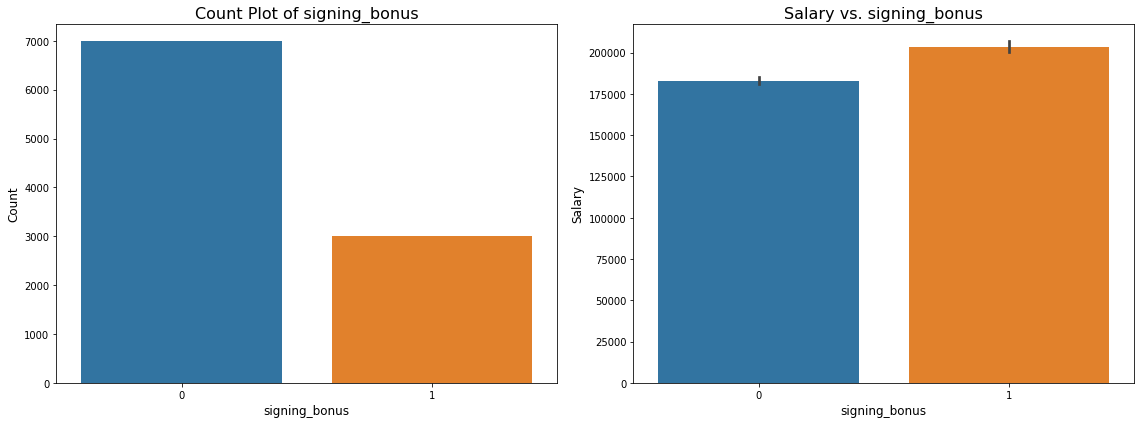

In [15]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='signing_bonus', data=data, ax=ax[0])
ax[0].set_xlabel('signing_bonus', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of signing_bonus', fontsize=16)

sns.barplot(x='signing_bonus', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('signing_bonus', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. signing_bonus', fontsize=16)
plt.tight_layout()
plt.show()

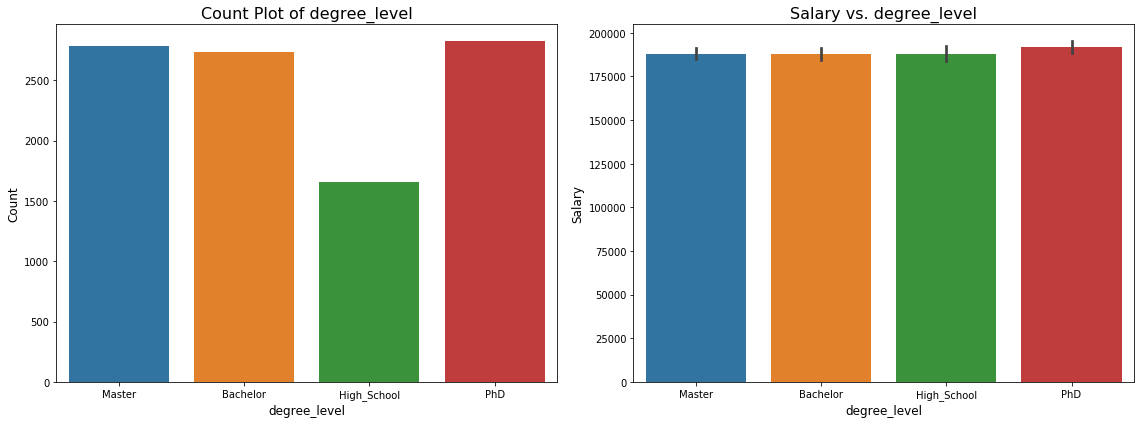

In [16]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='degree_level', data=data, ax=ax[0])
ax[0].set_xlabel('degree_level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of degree_level', fontsize=16)

sns.barplot(x='degree_level', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('degree_level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. degree_level', fontsize=16)
plt.tight_layout()
plt.show()

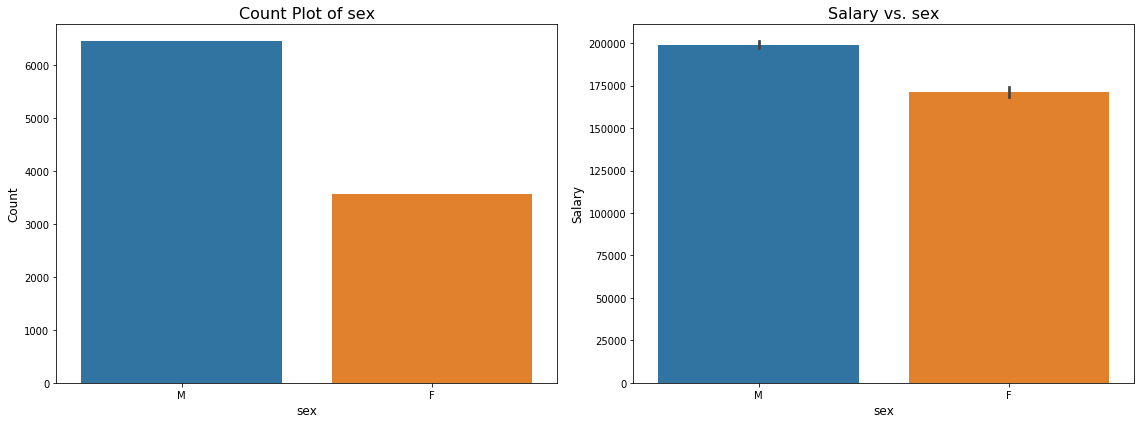

In [17]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='sex', data=data, ax=ax[0])
ax[0].set_xlabel('sex', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of sex', fontsize=16)

sns.barplot(x='sex', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('sex', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. sex', fontsize=16)
plt.tight_layout()
plt.show()

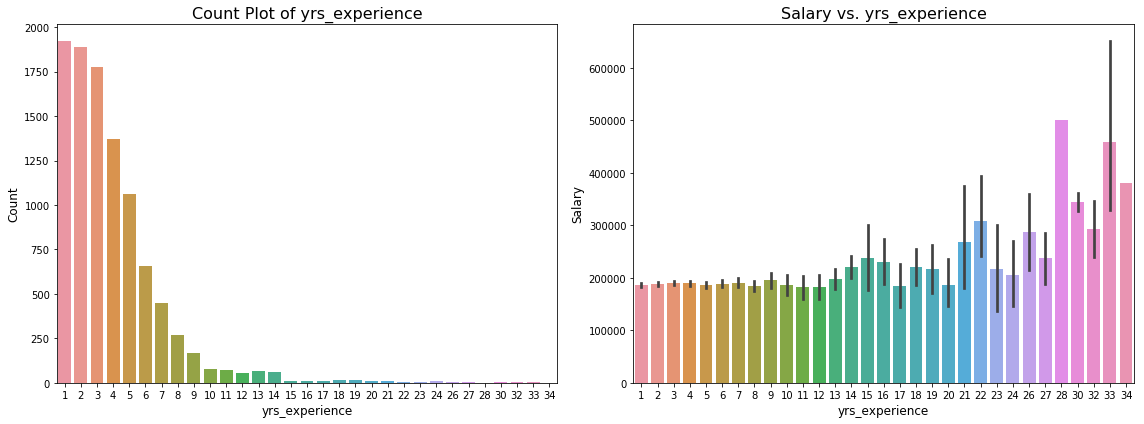

In [18]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='yrs_experience', data=data, ax=ax[0])
ax[0].set_xlabel('yrs_experience', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of yrs_experience', fontsize=16)

sns.barplot(x='yrs_experience', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('yrs_experience', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. yrs_experience', fontsize=16)
plt.tight_layout()
plt.show()

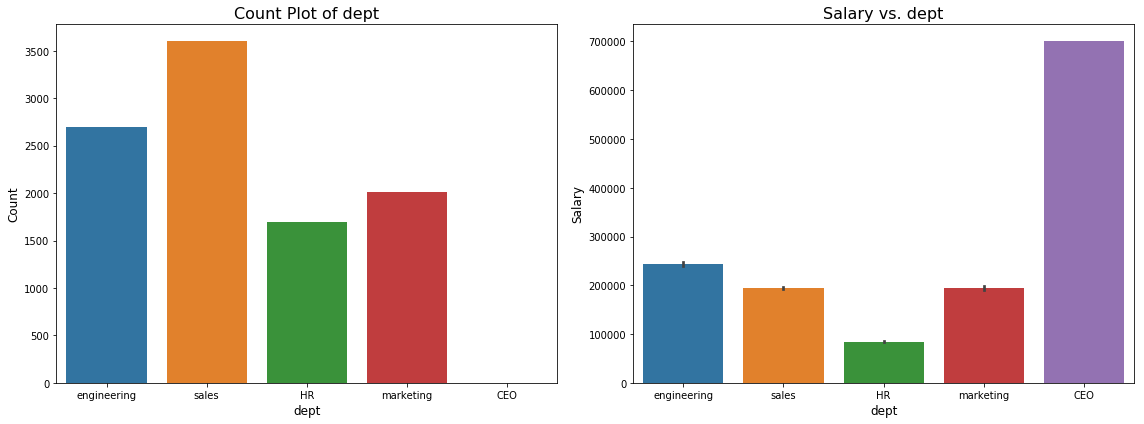

In [19]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dept', data=data, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dept', fontsize=16)

sns.barplot(x='dept', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. dept', fontsize=16)
plt.tight_layout()
plt.show()

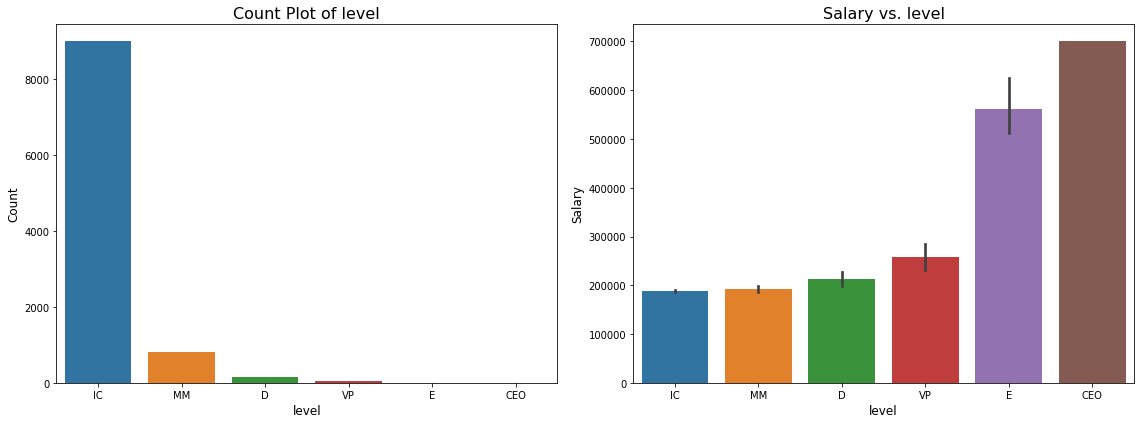

In [20]:
# visualization of 'signing_bonus'
orders = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='level', data=data, ax=ax[0], order=orders)
ax[0].set_xlabel('level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of level', fontsize=16)

sns.barplot(x='level', y='salary', data=data, ax=ax[1], order=orders)
ax[1].set_xlabel('level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. level', fontsize=16)
plt.tight_layout()
plt.show()

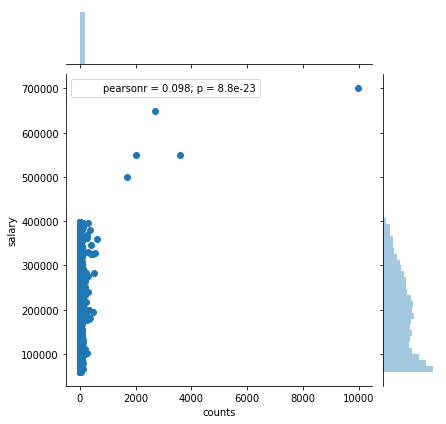

In [21]:
sns.jointplot(x='counts', y='salary', data=data, kind='scatter', size=6)
plt.show()

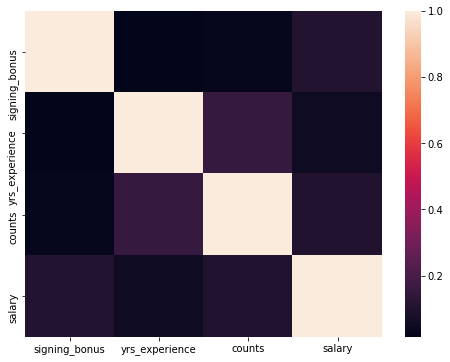

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
subset = data[['signing_bonus', 'yrs_experience', 'counts', 'salary']]
sns.heatmap(subset.corr(), ax=ax)
plt.show()

### Build Machine Learning Models with LightGBM

In [23]:
# drop useless features
data = data.drop(labels=['employee_id', 'boss_id'], axis=1)

# Question 4
Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?